In [42]:
import findspark
findspark.init('/opt/cloudera/parcels/SPARK2-2.3.0.cloudera3-1.cdh5.13.3.p0.458809/lib/spark2')
import pyspark


In [43]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('kmeansEder').getOrCreate()

In [44]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt, numpy as np

In [47]:
spark.sql("show tables").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
| default|     personas_reniec|      false|
| default|personas_reniec_j...|      false|
| default|personas_reniec_msar|      false|
| default|personas_reniec_part|      false|
| default|       piloto_ventas|      false|
| default|      piloto_ventas1|      false|
| default|      piloto_ventas2|      false|
| default|piloto_ventas_jhosep|      false|
| default| piloto_ventas_jonap|      false|
| default|piloto_ventas_victor|      false|
| default|  piloto_ventas_yhap|      false|
| default|           tmp_table|      false|
+--------+--------------------+-----------+



In [48]:
spark.sql("show tables from dnarvaez").show()

+--------+--------------------+-----------+
|database|           tableName|isTemporary|
+--------+--------------------+-----------+
|dnarvaez|     personas_reniec|      false|
|dnarvaez|       piloto_ventas|      false|
|dnarvaez|piloto_ventas_par...|      false|
|dnarvaez|piloto_ventas_par...|      false|
|dnarvaez|      stg_formato_01|      false|
|dnarvaez| stg_formato_01_hist|      false|
|dnarvaez|stg_formato_01_hi...|      false|
+--------+--------------------+-----------+



In [30]:
df1=spark.sql("select * from default.personas_reniec")

In [32]:
#df1.head(2)

In [49]:
ds = spark.read.csv("/user/epinedac/datasets/mtcars", header=True, nullValue="?", inferSchema=True)
ds.printSchema()
ds.count()
ds.show()

root
 |-- model: string (nullable = true)
 |-- mpg: double (nullable = true)
 |-- cyl: integer (nullable = true)
 |-- disp: double (nullable = true)
 |-- hp: integer (nullable = true)
 |-- drat: double (nullable = true)
 |-- wt: double (nullable = true)
 |-- qsec: double (nullable = true)
 |-- vs: integer (nullable = true)
 |-- am: integer (nullable = true)
 |-- gear: integer (nullable = true)
 |-- carb: integer (nullable = true)

+-------------------+----+---+-----+---+----+-----+-----+---+---+----+----+
|              model| mpg|cyl| disp| hp|drat|   wt| qsec| vs| am|gear|carb|
+-------------------+----+---+-----+---+----+-----+-----+---+---+----+----+
|          Mazda RX4|21.0|  6|160.0|110| 3.9| 2.62|16.46|  0|  1|   4|   4|
|      Mazda RX4 Wag|21.0|  6|160.0|110| 3.9|2.875|17.02|  0|  1|   4|   4|
|         Datsun 710|22.8|  4|108.0| 93|3.85| 2.32|18.61|  1|  1|   4|   1|
|     Hornet 4 Drive|21.4|  6|258.0|110|3.08|3.215|19.44|  1|  0|   3|   1|
|  Hornet Sportabout|18.7|  8|360

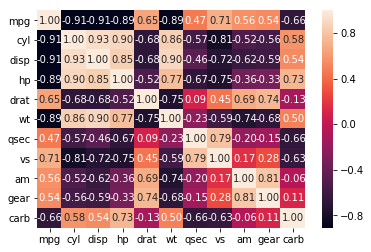

In [50]:

cluster_pd_df = ds.toPandas()
import seaborn as sns

spearman_corr = cluster_pd_df.corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt=".2f")


In [51]:
assembler = VectorAssembler(inputCols=["mpg", "cyl", "disp", "drat", "wt"], outputCol="features")
assem_data = assembler.transform(ds)

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(assem_data)
scaled_data = scaler_model.transform(assem_data)
scaled_data.show()


+-------------------+----+---+-----+---+----+-----+-----+---+---+----+----+--------------------+--------------------+
|              model| mpg|cyl| disp| hp|drat|   wt| qsec| vs| am|gear|carb|            features|     scaled_features|
+-------------------+----+---+-----+---+----+-----+-----+---+---+----+----+--------------------+--------------------+
|          Mazda RX4|21.0|  6|160.0|110| 3.9| 2.62|16.46|  0|  1|   4|   4|[21.0,6.0,160.0,3...|[0.15088482464765...|
|      Mazda RX4 Wag|21.0|  6|160.0|110| 3.9|2.875|17.02|  0|  1|   4|   4|[21.0,6.0,160.0,3...|[0.15088482464765...|
|         Datsun 710|22.8|  4|108.0| 93|3.85| 2.32|18.61|  1|  1|   4|   1|[22.8,4.0,108.0,3...|[0.44954344663064...|
|     Hornet 4 Drive|21.4|  6|258.0|110|3.08|3.215|19.44|  1|  0|   3|   1|[21.4,6.0,258.0,3...|[0.21725340731054...|
|  Hornet Sportabout|18.7|  8|360.0|175|3.15| 3.44|17.02|  0|  0|   3|   2|[18.7,8.0,360.0,3...|[-0.2307345256639...|
|            Valiant|18.1|  6|225.0|105|2.76| 3.46|20.22

In [52]:
import numpy as np
import pandas as pd
from pyspark.ml.clustering import KMeans

cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(scaled_data.sample(False,0.5, seed=42))
    cost[k] = model.computeCost(scaled_data) # requires Spark 2.0 or later



In [37]:
cost

array([     0.        ,      0.        , 103714.73805267,  56407.4186061 ,
        31702.35275389,  27019.88076611,  10722.62496638,   8039.38127044,
         6379.79209249,   5124.07435656,   5004.42143211,   4905.411671  ,
         4894.893996  ,   4546.86526   ,   4537.17501   ,   4476.81135   ,
         4464.646775  ,   4464.646775  ,   4457.831475  ,   4457.831475  ])

In [38]:
help(model.computeCost)

Help on method computeCost in module pyspark.ml.clustering:

computeCost(self, dataset) method of pyspark.ml.clustering.KMeansModel instance
    Return the K-means cost (sum of squared distances of points to their nearest center)
    for this model on the given data.
    
    .. versionadded:: 2.0.0



In [39]:
cost[2:20]

array([103714.73805267,  56407.4186061 ,  31702.35275389,  27019.88076611,
        10722.62496638,   8039.38127044,   6379.79209249,   5124.07435656,
         5004.42143211,   4905.411671  ,   4894.893996  ,   4546.86526   ,
         4537.17501   ,   4476.81135   ,   4464.646775  ,   4464.646775  ,
         4457.831475  ,   4457.831475  ])

Text(0,0.5,'cost')

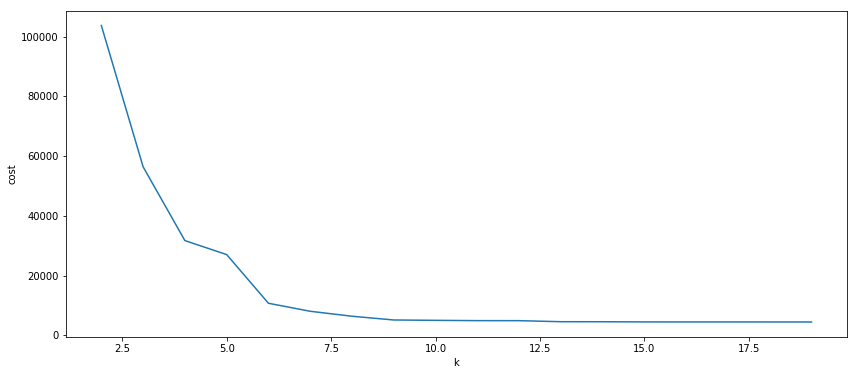

In [37]:
fig, ax = plt.subplots(1,1, figsize =(14,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [38]:
clusters = 5

from pyspark.ml.clustering import KMeans

## Puedes utiliizar también métodos para pasar los hiper-parámetros
kmeans = KMeans()\
         .setK(clusters)\
         .setMaxIter(1000)\
         .setFeaturesCol("scaled_features")\
         .setPredictionCol("cluster")

model = kmeans.fit(scaled_data)
## Calculamos la distancia de los puntos a su centro más cercano
## Entre más pequeño
wssse = model.computeCost(scaled_data)

predict = model.transform(scaled_data)
df_pandas=predict.toPandas()


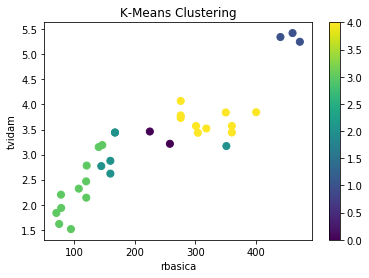

In [39]:
wh1 = df_pandas.loc[:,['disp', 'wt']]

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wh1['disp'],wh1['wt'],
                     c=df_pandas['cluster'],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('rbasica')
ax.set_ylabel('tvidam')
plt.colorbar(scatter)

In [42]:
predict.show(10)

+-----------------+----+---+-----+---+----+-----+-----+---+---+----+----+--------------------+--------------------+-------+
|            model| mpg|cyl| disp| hp|drat|   wt| qsec| vs| am|gear|carb|            features|     scaled_features|cluster|
+-----------------+----+---+-----+---+----+-----+-----+---+---+----+----+--------------------+--------------------+-------+
|        Mazda RX4|21.0|  6|160.0|110| 3.9| 2.62|16.46|  0|  1|   4|   4|[21.0,6.0,160.0,3...|[0.15088482464765...|      2|
|    Mazda RX4 Wag|21.0|  6|160.0|110| 3.9|2.875|17.02|  0|  1|   4|   4|[21.0,6.0,160.0,3...|[0.15088482464765...|      2|
|       Datsun 710|22.8|  4|108.0| 93|3.85| 2.32|18.61|  1|  1|   4|   1|[22.8,4.0,108.0,3...|[0.44954344663064...|      3|
|   Hornet 4 Drive|21.4|  6|258.0|110|3.08|3.215|19.44|  1|  0|   3|   1|[21.4,6.0,258.0,3...|[0.21725340731054...|      0|
|Hornet Sportabout|18.7|  8|360.0|175|3.15| 3.44|17.02|  0|  0|   3|   2|[18.7,8.0,360.0,3...|[-0.2307345256639...|      4|
|       

In [40]:
predict.groupBy('cluster').count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1|    3|
|      3|   11|
|      4|   10|
|      2|    6|
|      0|    2|
+-------+-----+



In [41]:
from pyspark.sql.functions import col

for i in range(clusters):
    predictionPerCol = predict.filter(col("cluster") == i)
    print("cluster {}".format(i))
    for c in predictionPerCol.select(col("features"), col("cluster")).collect():
        print(c)
    print("="*75)


cluster 0
Row(features=DenseVector([21.4, 6.0, 258.0, 3.08, 3.215]), cluster=0)
Row(features=DenseVector([18.1, 6.0, 225.0, 2.76, 3.46]), cluster=0)
cluster 1
Row(features=DenseVector([10.4, 8.0, 472.0, 2.93, 5.25]), cluster=1)
Row(features=DenseVector([10.4, 8.0, 460.0, 3.0, 5.424]), cluster=1)
Row(features=DenseVector([14.7, 8.0, 440.0, 3.23, 5.345]), cluster=1)
cluster 2
Row(features=DenseVector([21.0, 6.0, 160.0, 3.9, 2.62]), cluster=2)
Row(features=DenseVector([21.0, 6.0, 160.0, 3.9, 2.875]), cluster=2)
Row(features=DenseVector([19.2, 6.0, 167.6, 3.92, 3.44]), cluster=2)
Row(features=DenseVector([17.8, 6.0, 167.6, 3.92, 3.44]), cluster=2)
Row(features=DenseVector([15.8, 8.0, 351.0, 4.22, 3.17]), cluster=2)
Row(features=DenseVector([19.7, 6.0, 145.0, 3.62, 2.77]), cluster=2)
cluster 3
Row(features=DenseVector([22.8, 4.0, 108.0, 3.85, 2.32]), cluster=3)
Row(features=DenseVector([24.4, 4.0, 146.7, 3.69, 3.19]), cluster=3)
Row(features=DenseVector([22.8, 4.0, 140.8, 3.92, 3.15]), clus

In [53]:
spark.stop()

In [31]:
data_tp=predict.toPandas()

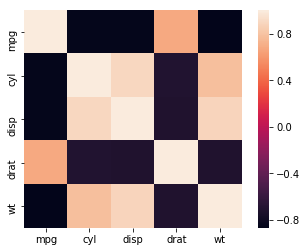

In [32]:
import seaborn as sns

wh1 = data_tp[['mpg', 'cyl', 'disp', 'drat', 'wt']] 
cor = wh1.corr() #Calculate the correlation of the above variables
sns.heatmap(cor, square = True) #Plot the correlation as heat map


In [57]:
data_tp.columns

Index([u'model', u'mpg', u'cyl', u'disp', u'hp', u'drat', u'wt', u'qsec',
       u'vs', u'am', u'gear', u'carb', u'features', u'scaled_features',
       u'prediction'],
      dtype='object')

In [60]:
data_tp['prediction']

0     4
1     4
2     4
3     0
4     0
5     0
6     0
7     4
8     4
9     4
10    4
11    0
12    0
13    0
14    1
15    1
16    1
17    2
18    5
19    2
20    4
21    0
22    0
23    3
24    0
25    2
26    2
27    2
28    3
29    4
30    3
31    4
Name: prediction, dtype: int64

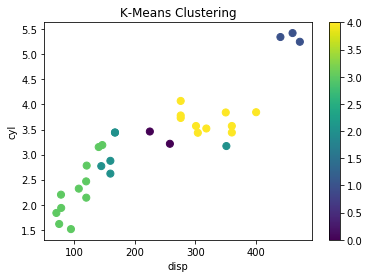

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(wh1['disp'],wh1['wt'],
                     c=data_tp['prediction'],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('disp')
ax.set_ylabel('cyl')
plt.colorbar(scatter)

# 'mpg', 'cyl', 'disp', 'drat', 'wt'

In [9]:

## Imprimimos los centros de los clusters
for center in model.clusterCenters():
    print(center)


[ 0.41304073 -1.22485777 -0.83429857  0.48148071 -0.44585485]
[-0.59990977  1.01488215  0.72982151 -0.98482035  0.46655069]
[-0.71190675  1.01488215  0.97046468  1.16600392 -0.0482903 ]
[ 2.16683052 -1.22485777 -1.25724961  1.03508418 -1.22616472]
[-0.05817621 -0.10498781 -0.57029708  0.47774015 -0.19239467]
[-1.37006186  1.01488215  1.82841574 -1.01599172  2.16914561]
[-0.98567715  1.01488215  0.7647178   0.07188896  0.49848872]
[-0.056517   -0.10498781  0.08696336 -1.26536265  0.12289753]
[ 1.29574288 -1.22485777 -1.12196768  1.65227723 -1.34965843]
[ 1.71054652 -1.22485777 -1.09426581  0.32437703 -1.74177223]


In [10]:
predict = model.transform(scaled_data)
predict.show(1000)
print("="*15)


+-------------------+----+---+-----+---+----+-----+-----+---+---+----+----+--------------------+--------------------+----------+
|              model| mpg|cyl| disp| hp|drat|   wt| qsec| vs| am|gear|carb|            features|     scaled_features|prediction|
+-------------------+----+---+-----+---+----+-----+-----+---+---+----+----+--------------------+--------------------+----------+
|          Mazda RX4|21.0|  6|160.0|110| 3.9| 2.62|16.46|  0|  1|   4|   4|[21.0,6.0,160.0,3...|[0.15088482464765...|         4|
|      Mazda RX4 Wag|21.0|  6|160.0|110| 3.9|2.875|17.02|  0|  1|   4|   4|[21.0,6.0,160.0,3...|[0.15088482464765...|         4|
|         Datsun 710|22.8|  4|108.0| 93|3.85| 2.32|18.61|  1|  1|   4|   1|[22.8,4.0,108.0,3...|[0.44954344663064...|         0|
|     Hornet 4 Drive|21.4|  6|258.0|110|3.08|3.215|19.44|  1|  0|   3|   1|[21.4,6.0,258.0,3...|[0.21725340731054...|         7|
|  Hornet Sportabout|18.7|  8|360.0|175|3.15| 3.44|17.02|  0|  0|   3|   2|[18.7,8.0,360.0,3...|[

In [11]:

from pyspark.sql.functions import col

for i in range(clusters):
    predictionPerCol = predict.filter(col("prediction") == i)
    print("cluster {}".format(i))
    for c in predictionPerCol.select(col("features"), col("prediction")).collect():
        print(c)
    print("="*75)


cluster 0
Row(features=DenseVector([22.8, 4.0, 108.0, 3.85, 2.32]), prediction=0)
Row(features=DenseVector([24.4, 4.0, 146.7, 3.69, 3.19]), prediction=0)
Row(features=DenseVector([22.8, 4.0, 140.8, 3.92, 3.15]), prediction=0)
Row(features=DenseVector([21.5, 4.0, 120.1, 3.7, 2.465]), prediction=0)
Row(features=DenseVector([21.4, 4.0, 121.0, 4.11, 2.78]), prediction=0)
cluster 1
Row(features=DenseVector([18.7, 8.0, 360.0, 3.15, 3.44]), prediction=1)
Row(features=DenseVector([14.3, 8.0, 360.0, 3.21, 3.57]), prediction=1)
Row(features=DenseVector([16.4, 8.0, 275.8, 3.07, 4.07]), prediction=1)
Row(features=DenseVector([17.3, 8.0, 275.8, 3.07, 3.73]), prediction=1)
Row(features=DenseVector([15.2, 8.0, 275.8, 3.07, 3.78]), prediction=1)
Row(features=DenseVector([15.5, 8.0, 318.0, 2.76, 3.52]), prediction=1)
Row(features=DenseVector([15.2, 8.0, 304.0, 3.15, 3.435]), prediction=1)
Row(features=DenseVector([19.2, 8.0, 400.0, 3.08, 3.845]), prediction=1)
cluster 2
Row(features=DenseVector([15.8, 

In [21]:
spark.stop()

In [1]:
import platform
platform.platform()

'Linux-3.10.0-327.el7.x86_64-x86_64-with-redhat-7.2-Maipo'

In [2]:
platform.system()

'Linux'

In [3]:
platform.release()

'3.10.0-327.el7.x86_64'

In [4]:
platform.version()

'#1 SMP Thu Oct 29 17:29:29 EDT 2015'

In [5]:
import platform
import sys

def linux_distribution():
  try:
    return platform.linux_distribution()
  except:
    return "N/A"

print("""Python version: %s
dist: %s
linux_distribution: %s
system: %s
machine: %s
platform: %s
uname: %s
version: %s
mac_ver: %s
""" % (
sys.version.split('\n'),
str(platform.dist()),
linux_distribution(),
platform.system(),
platform.machine(),
platform.platform(),
platform.uname(),
platform.version(),
platform.mac_ver(),
))

Python version: ['2.7.5 (default, Aug  2 2016, 04:20:16) ', '[GCC 4.8.5 20150623 (Red Hat 4.8.5-4)]']
dist: ('redhat', '7.2', 'Maipo')
linux_distribution: ('Red Hat Enterprise Linux Server', '7.2', 'Maipo')
system: Linux
machine: x86_64
platform: Linux-3.10.0-327.el7.x86_64-x86_64-with-redhat-7.2-Maipo
uname: ('Linux', 'lmavtbigdata02.nextelperu.net', '3.10.0-327.el7.x86_64', '#1 SMP Thu Oct 29 17:29:29 EDT 2015', 'x86_64', 'x86_64')
version: #1 SMP Thu Oct 29 17:29:29 EDT 2015
mac_ver: ('', ('', '', ''), '')



In [6]:
import os
print os.name

posix


In [ ]:
spark.